# 리뷰토픽모델링


## 라이브러리 임포트


In [1]:
import os
import re
import warnings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
import joblib
import pyLDAvis
from konlpy.tag import Okt
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Font directories:
	/System/Library/Assets/com_apple_MobileAsset_Font3
	/System/Library/Assets/com_apple_MobileAsset_Font4
	/System/Library/Fonts
	/Library/Fonts
	/Users/registry/Library/Fonts
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7
	/Users/registry/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/Users/registry/.fonts
	/System/Library/Fonts/Supplemental
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0818d874bf1d0e24a1fe62e79f407717792c5ee1.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0ab217c39c45c7c6acaddfa199fd32c55a7b4a19.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/10b097deccb3c6126d986e24b1980031ff7399da.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/12cc699be28fb04f3e3c4969a0378a87b920b174.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/157acc4d862730d6d5beaa943546f80a71948c7b.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/18189590ed3a5f46cef20ed4d1cec2611dca13ff.asset
	/System/L

## 데이터 로드 및 정제


- 젠트리피케이션 지역
  - 대학로, 북촌, 서촌, 홍대입구역, 합정, 연남, 해방촌, 경리단길, 종로3가, 성수동, 신사동 가로수길, 송리단길, 명동, 신림, 문래, 이수역, 용리단길
- 비젠트리피케이션 지역
  - 강남역, 압구정로데오, 건대입구역, 여의도역, 동대문, 잠실역, 회기역, 영등포, 청담, 사당
- 기본 상권 지역
  - 성내동, 시흥동, 삼양동, 중화동, 월계동, 응암동, 신도림동, 신정동, 도봉동, 방화동


In [5]:
df = pd.read_csv("../data/mining/kakao_map_place_comment.csv")

In [6]:
# 지역별 분류
yg_regions = [
    '대학로', '북촌', '서촌', '홍대입구역', '합정', '연남',
    '해방촌', '경리단길', '종로3가', '성수동', '신사동 가로수길',
    '송리단길', '명동', '신림', '문래', '이수역', '용리단길'
]
ng_regions = [
    '강남역', '압구정로데오', '건대입구역', '여의도역',
    '동대문', '잠실역', '회기역', '영등포', '청담', '사당'
]
nm_regions = [
    '성내동', '시흥동', '삼양동', '중화동', '월계동',
    '응암동', '신도림동', '신정동', '도봉동', '방화동'
]

In [7]:
# 지역별 카테고리 추가
def categorize_region(region):
  match region:
    case _ if region in yg_regions:
      return '젠트리피케이션'
    case _ if region in ng_regions:
      return '비젠트리피케이션'
    case _ if region in nm_regions:
      return '기본상권지'
    case _:
      return '기타'

df['category'] = df['region'].apply(categorize_region)

# '기타' 지역 제외
df = df[df['category'] != '기타']

In [8]:
# OKT 인스턴스 생성 (한 번만 초기화)
okt = Okt()

def preprocess_text(text):
  if pd.isna(text):
    return ""

  text = str(text)
  text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)

  if text.strip():
    tokens = okt.nouns(text)
    return " ".join(tokens)

  return ""

# 데이터프레임에 적용
df['cleaned_comment'] = df['contents'].apply(preprocess_text)

In [9]:
# CountVectorizer 적용
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words=None
)
dtm = vectorizer.fit_transform(df['cleaned_comment'])

In [10]:
# LDA 모델 적용 (토픽 개수 3개)
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [11]:
lda.components_

array([[7.07831876e+01, 2.76574639e+02, 8.96257193e+00, ...,
        3.52456697e+01, 3.43890342e-01, 3.47320150e-01],
       [9.20648974e+02, 3.69876902e+03, 5.11843571e+00, ...,
        8.93156196e+01, 7.17453981e-01, 1.90453796e+01],
       [5.41567839e+02, 2.10656339e+02, 2.66918992e+02, ...,
        2.44387108e+01, 7.89386557e+01, 7.66073002e+01]])

## 모델링 및 분석


In [12]:
# 각 토픽별 주요 단어 출력
def print_top_words(model, feature_names, n_top_words):
  for topic_idx, topic in enumerate(model.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx + 1}:")
    print(" ".join(top_words))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic 1:
맛집 진짜 최고 김치 가성 칼국수 고기 만두 정말 여기

Topic 2:
가격 방문 정도 고기 웨이 생각 국물 사람 시간 포장

Topic 3:
직원 커피 분위기 사람 카페 손님 사장 음식 주문 자리



In [13]:
# 문서별 토픽 분포
doc_topic_dist = lda.transform(dtm)
df['topic'] = doc_topic_dist.argmax(axis=1)

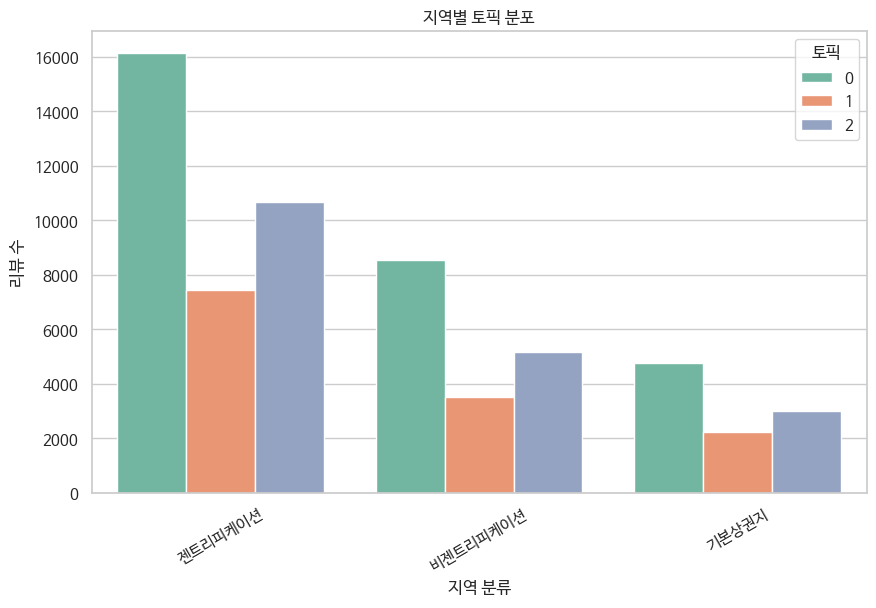

In [14]:
# 지역별 토픽 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', hue='topic', palette='Set2')
plt.title("지역별 토픽 분포")
plt.xlabel("지역 분류")
plt.ylabel("리뷰 수")
plt.legend(title="토픽")
plt.xticks(rotation=30)
plt.show()

In [15]:
# pyLDAvis 활성화
pyLDAvis.enable_notebook()

# 단어 목록 및 빈도 계산
vocab = vectorizer.get_feature_names_out()
term_frequency = np.asarray(dtm.sum(axis=0)).flatten()

# BrokenProcessPool 오류 방지를 위해 `joblib` 사용 안 함
joblib.parallel_backend('threading')

# LDA 시각화 실행
lda_visualization = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(dtm),
    doc_lengths=[len(doc.split()) for doc in df['cleaned_comment']],
    vocab=vocab,
    term_frequency=term_frequency
)

pyLDAvis.display(lda_visualization)

Topic 1 카페 및 분위기,
Topic 2 서비스 및 방문 경험,
Topic 3 음식 및 맛집
로 추정..?


In [16]:
df['category'].value_counts()

category
젠트리피케이션     34269
비젠트리피케이션    17229
기본상권지       10040
Name: count, dtype: int64

In [17]:
df['category'] = df['category'].str.strip()

In [18]:
df['region'].unique()

array(['대학로', '북촌', '서촌', '홍대입구역', '합정', '연남', '해방촌', '경리단길', '종로3가',
       '성수동', '송리단길', '명동', '신림', '문래', '이수역', '용리단길', '강남역', '압구정로데오',
       '건대입구역', '여의도역', '동대문', '잠실역', '회기역', '영등포', '청담', '사당', '성내동',
       '시흥동', '삼양동', '중화동', '월계동', '응암동', '신도림동', '신정동', '도봉동', '방화동'],
      dtype=object)

### 지역별 토픽 비율 분석


- Topic 1 (가장 큰 비중)
  모든 지역에서 40~50%로 가장 높은 비중을 차지
  비젠트리피케이션 지역(49.3%)이 가장 높고, 일반상권지(46.3%)가 가장 낮음
  비젠트리피케이션 지역에서 특정 주제가 더 강하게 나타날 가능성 있음

- Topic 2 (가장 낮은 비중)
  젠트리피케이션(20.9%)에서 가장 낮고, 일반상권지(23.5%)에서 가장 높음
  일반상권지가 상대적으로 더 다양한 토픽을 포함하고 있을 가능성 있음

- Topic 3 (거의 비슷함)
  젠트리피케이션(30.5%)과 일반상권지(30.2%)가 거의 비슷하고, 비젠트리피케이션(29.3%)이 가장 낮음

세 지역 모두 큰 차이는 없음


<Figure size 1000x600 with 0 Axes>

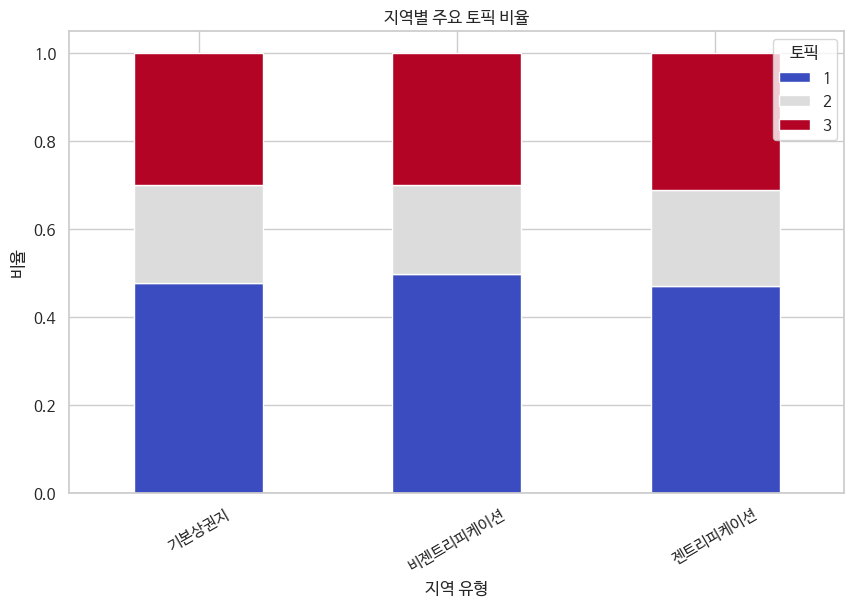

In [19]:
# LDA 모델로 각 리뷰가 어느 토픽에 속하는지 확률 계산
doc_topic_dist = lda.transform(dtm)

# 각 리뷰에 가장 높은 확률을 가진 토픽 할당
df['topic'] = doc_topic_dist.argmax(axis=1)

df['topic'] = df['topic'] + 1

# 지역별 토픽 분포 분석
topic_distribution = df.groupby('category')['topic'].value_counts(normalize=True).unstack()

plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))
plt.title("지역별 주요 토픽 비율")
plt.xlabel("지역 유형")
plt.ylabel("비율")
plt.legend(title="토픽")
plt.xticks(rotation=30)
plt.show()

In [20]:
topic_distribution

topic,1,2,3
category,,,
기본상권지,0.476295,0.223008,0.300697
비젠트리피케이션,0.496663,0.203204,0.300133
젠트리피케이션,0.470921,0.217456,0.311623
